In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Epoch 1/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - accuracy: 0.8209 - loss: 0.7447 - val_accuracy: 0.8262 - val_loss: 0.6358
Epoch 2/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8285 - loss: 0.6490 - val_accuracy: 0.8262 - val_loss: 0.6225
Epoch 3/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8271 - loss: 0.6333 - val_accuracy: 0.8262 - val_loss: 0.6159
Epoch 4/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.8283 - loss: 0.6247 - val_accuracy: 0.8262 - val_loss: 0.6150
Epoch 5/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.8289 - loss: 0.6185 - val_accuracy: 0.8262 - val_loss: 0.6159
Epoch 6/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 44s 41ms/step - accuracy: 0.8269 - loss: 0.6181 - val_accuracy: 0.8262 - val_loss: 0.6103
Epoch 7/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8271 - loss: 0.6129 - val_accuracy: 0.8262 - val_loss: 0.5884
Epoch 8/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 44s 40ms/step - accuracy: 0.8277 -

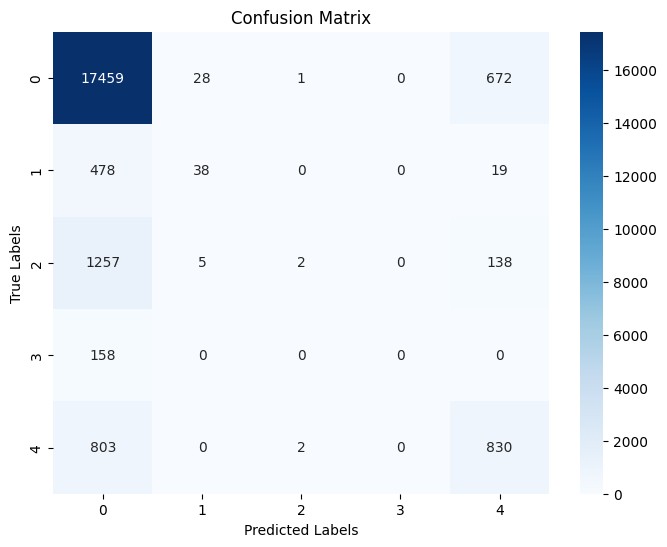

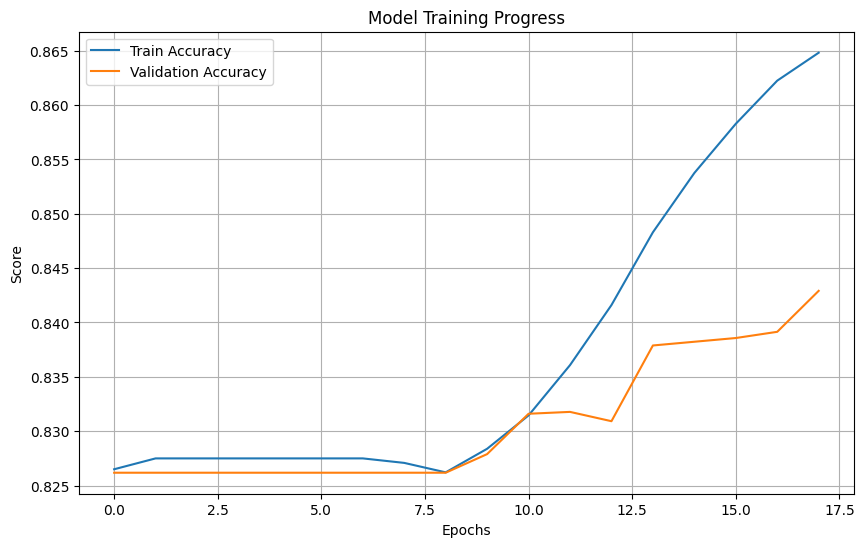

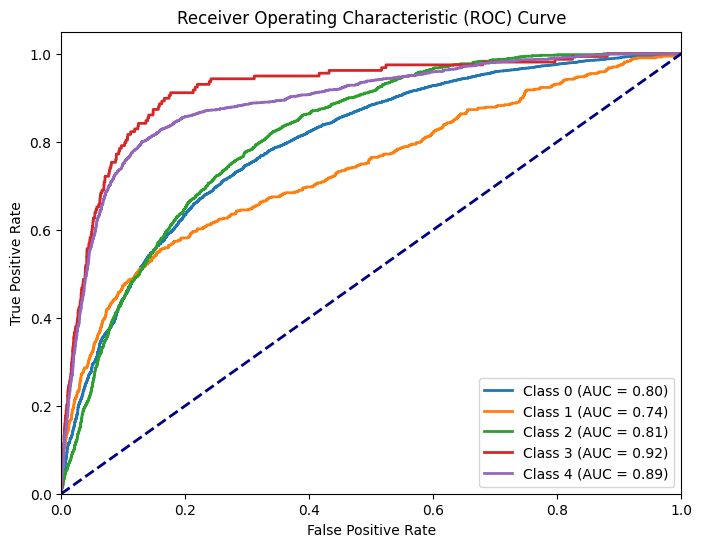

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets - adjust paths as necessary
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
test_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv', header=None)

# Concatenate train and test for preprocessing
df = pd.concat([train_df, test_df], ignore_index=True)

# Drop rows with missing labels if any - assuming the last column is the label
df = df.dropna(subset=[df.columns[-1]])

# Assuming the first column contains the sequences and the last column contains the labels
# Adjust column indices as per your dataset
sequences = df.iloc[:, :-1].values  # All columns except the last one
labels = df.iloc[:, -1].values  # Last column

# Convert sequences to a list of strings
sequences = [' '.join(map(str, seq)) for seq in sequences]

# Tokenization and Padding of sequences
tokenizer = Tokenizer(num_words=10000)  # Adjust vocabulary size as needed
tokenizer.fit_on_texts(sequences)
sequences_tokenized = tokenizer.texts_to_sequences(sequences)
X = pad_sequences(sequences_tokenized, padding='post')

# Encode labels
lb = LabelBinarizer()
y = lb.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions and calculate metrics
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot F1 score and accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Model Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test.shape[1]):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
